In [30]:
import pandas as pd
from typing import Dict, Tuple, List, Any

In [31]:
TRAIN_PATH = "../../../data/processed/trainset.csv"
TEST_PATH = "../../../data/processed/testset.csv"
VAL_PATH = "../../../data/processed/valset.csv"
SAVE_DIR = "../../../data/pyts/models"

def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    return df   
df_train = load_data(TRAIN_PATH)
df_test = load_data(TEST_PATH)
df_val = load_data(VAL_PATH)

In [32]:
dataframes = [df_train, df_test, df_val]

# Liste der Indizes, die nicht negativ sein dürfen
non_negative_cols = ["wdvi", "mcari", "masvi2", "reip", "mtci"]

for df in dataframes:
    # Clip negative Werte nur bei Indizes, die nicht negativ sein dürfen
    df[non_negative_cols] = df[non_negative_cols].clip(lower=0)


In [33]:
import pandas as pd

def check_negative_values(df: pd.DataFrame, name: str):
    numeric_cols = df.select_dtypes(include='number').columns
    has_negative = (df[numeric_cols] < 0).any().any()
    if has_negative:
        neg_counts = (df[numeric_cols] < 0).sum()
        print(f"{name}: Negative Werte gefunden in Spalten:")
        print(neg_counts[neg_counts > 0])
    else:
        print(f"{name}: Keine negativen Werte gefunden.")

check_negative_values(df_train, "Train")
check_negative_values(df_test, "Test")
check_negative_values(df_val, "Validation")


Train: Negative Werte gefunden in Spalten:
ndvi             2553
gndvi            5324
savi             2553
dvi              2553
ndmi           162173
nbr             16755
ndwi          2947982
rendvi           2531
biweek_sin    1500848
biweek_cos    1540344
dtype: int64
Test: Negative Werte gefunden in Spalten:
ndvi             822
gndvi           1633
savi             822
dvi              822
ndmi           44905
nbr             5269
ndwi          841925
rendvi           849
biweek_sin    428792
biweek_cos    440076
dtype: int64
Validation: Negative Werte gefunden in Spalten:
ndvi             490
gndvi            930
savi             490
dvi              490
ndmi           22871
nbr             2533
ndwi          420834
rendvi           569
biweek_sin    214472
biweek_cos    220116
dtype: int64


In [34]:
print(df_train.id.unique())
print(df_test.id.unique())
print(df_val.id.unique())

[    4     6     7 ... 28208 28209 28210]
[    1     2     5 ... 28188 28195 28201]
[    3    44    49 ... 28204 28211 28212]


In [35]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


class TimeSeriesPreprocessor:
    """
    Prepares multivariate time series data for RandomForest classification.
    Handles automatic feature selection, encoding, and padding per ID.
    """

    def __init__(
        self,
        feature_cols: Optional[List[str]] = None,
        label_col: str = "species",
        id_col: str = "id",
        fixed_seq_len: int = 26
    ):
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.id_col = id_col
        self.max_len = fixed_seq_len 

        self.label_encoder = LabelEncoder()
        self.ohe: Optional[OneHotEncoder] = None
        self.max_len: Optional[int] = None

        self.drop_cols = [
            "time",
            "disturbance_year",
            "doy",
            "is_disturbed",
            "date_diff",
            "year",
        ]

    # -----------------------------------------------------
    def load_csv(self, path: str) -> pd.DataFrame:
        df = pd.read_csv(path)
        if "time" in df.columns:
            df = df.sort_values(by=[self.id_col, "time"])
        return df

    # -----------------------------------------------------
    def _encode_categoricals(self, df: pd.DataFrame, fit: bool = False) -> pd.DataFrame:
        """One-hot encodes categorical variables using sklearn's OneHotEncoder."""
        categorical_cols = [
            c
            for c in ["season", "is_growing_season", "month_num", "week_of_year","biweek_of year"]
            if c in df.columns and c not in self.drop_cols + [self.label_col]
        ]

        if not categorical_cols:
            return df

        if fit or self.ohe is None:
            self.ohe = OneHotEncoder(
                drop="first", handle_unknown="ignore", sparse_output=False
            )
            encoded = self.ohe.fit_transform(df[categorical_cols])
        else:
            encoded = self.ohe.transform(df[categorical_cols])

        encoded_df = pd.DataFrame(
            encoded,
            columns=self.ohe.get_feature_names_out(categorical_cols),
            index=df.index,
        )

        df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)
        return df

    # -----------------------------------------------------
    def _select_features(self, df: pd.DataFrame) -> List[str]:
        if self.feature_cols is not None:
            return self.feature_cols
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols = [
            c for c in numeric_cols
            if c not in self.drop_cols + [self.label_col, self.id_col]
        ]
        print(f"Auto-detected {len(feature_cols)} feature columns (excluded '{self.id_col}').")
        return feature_cols


    # -----------------------------------------------------
    def pad_group(self, group: pd.DataFrame) -> np.ndarray:
        data = group[self.feature_cols].to_numpy()
        padded = np.zeros((self.max_len, len(self.feature_cols)))
        length = min(data.shape[0], self.max_len)
        padded[:length, :] = data[:length, :]
        return padded

    # -----------------------------------------------------
    def transform(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        df = self._encode_categoricals(df, fit=False)

        if self.feature_cols is None:
            self.feature_cols = self._select_features(df)

        grouped = list(df.groupby(self.id_col))

        X = np.stack([self.pad_group(g) for _, g in grouped])
        y = np.array([g[self.label_col].iloc[0] for _, g in grouped])
        y_encoded = self.label_encoder.transform(y)
        return X, y_encoded

    # -----------------------------------------------------
    def prepare_dataset(self, csv_path: str, fit: bool = False) -> Tuple[np.ndarray, np.ndarray]:
        """Loads, encodes, and transforms dataset. If `fit=True`, fits encoders & sets max_len."""
        df = self.load_csv(csv_path)
        df = df.drop(columns=[c for c in self.drop_cols if c in df.columns], errors="ignore")

        # Fit encoder and determine max_len only on training data
        df = self._encode_categoricals(df, fit=fit)

        if fit:
            self.feature_cols = self._select_features(df)
            grouped = list(df.groupby(self.id_col))
            self.max_len = max(len(g) for _, g in grouped)
            # Fit label encoder
            y = np.array([g[self.label_col].iloc[0] for _, g in grouped])
            self.label_encoder.fit(y)

        return self.transform(df)


In [36]:
import numpy as np
from typing import List, Tuple, Dict

class PytsDatasetBuilder:
    """Manages train/test/validation dataset preparation."""

    def __init__(
        self,
        train_path: str,
        test_path: str,
        valid_path: str,
        feature_cols: List[str] = None,
    ):
        self.train_path = train_path
        self.test_path = test_path
        self.valid_path = valid_path
        self.preprocessor = TimeSeriesPreprocessor(feature_cols)

    def build(self) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
        """Creates X_train, y_train, X_test, y_test, X_valid, y_valid."""
        print("Preparing training data (fit)...")
        X_train, y_train = self.preprocessor.prepare_dataset(self.train_path, fit=True)

        print("Preparing test data (transform only)...")
        X_test, y_test = self.preprocessor.prepare_dataset(self.test_path, fit=False)

        print("Preparing validation data (transform only)...")
        X_valid, y_valid = self.preprocessor.prepare_dataset(self.valid_path, fit=False)

        return {
            "train": (X_train, y_train),
            "test": (X_test, y_test),
            "valid": (X_valid, y_valid),
        }


In [37]:
import os
from datetime import datetime
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

class FlattenedRandomForestModel:
    """
    A RandomForestClassifier wrapper that flattens multivariate time series.
    Supports optional feature scaling, hyperparameter tuning, and timestamped saving.
    """

    def __init__(
        self,
        n_estimators: int = 200,
        max_depth: int = None,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        random_state: int = 42,
        n_jobs: int = -1,
        scaler: object = StandardScaler(),
    ):
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=n_jobs,
        )
        self.scaler = scaler
        self.is_trained = False

    def _flatten(self, X: np.ndarray) -> np.ndarray:
        if X.ndim == 3:
            n_samples, n_timestamps, n_features = X.shape
            return X.reshape(n_samples, n_timestamps * n_features)
        elif X.ndim == 2:
            return X
        else:
            raise ValueError(f"Unexpected X shape: {X.shape}")

    def _scale(self, X: np.ndarray, fit: bool = False) -> np.ndarray:
        X_flat = self._flatten(X)
        if self.scaler is not None:
            if fit:
                X_flat = self.scaler.fit_transform(X_flat)
            else:
                X_flat = self.scaler.transform(X_flat)
        return X_flat

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X_flat = self._scale(X_train, fit=True)
        self.model.fit(X_flat, y_train)
        self.is_trained = True

    def grid_search(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        param_grid: dict,
        cv: int = 3,
        scoring: str = "accuracy",
    ):
        X_flat = self._scale(X_train, fit=True)
        grid = GridSearchCV(
            estimator=self.model,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose= 2
        )
        grid.fit(X_flat, y_train)
        self.model = grid.best_estimator_
        self.is_trained = True
        return grid.best_params_, grid.best_score_

    def predict(self, X: np.ndarray) -> np.ndarray:
        if not self.is_trained:
            raise RuntimeError("Model must be trained before prediction.")
        X_flat = self._scale(X, fit=False)
        return self.model.predict(X_flat)

    def evaluate(
        self, X: np.ndarray, y: np.ndarray, label_encoder=None, set_name: str = "Test"
    ):
        if not self.is_trained:
            raise RuntimeError("Model must be trained before evaluation.")
        X_flat = self._scale(X, fit=False)
        y_pred = self.model.predict(X_flat)
        acc = accuracy_score(y, y_pred)
        print(f"{set_name} Accuracy: {acc:.4f}")

        if label_encoder is not None:
            y_true_labels = label_encoder.inverse_transform(y)
            y_pred_labels = label_encoder.inverse_transform(y_pred)
        else:
            y_true_labels, y_pred_labels = y, y_pred

        print("Classification Report:")
        print(classification_report(y_true_labels, y_pred_labels))
        print("Confusion Matrix:")
        print(confusion_matrix(y_true_labels, y_pred_labels))

        # Weighted accuracy based on F1-score
        report = classification_report(y, y_pred, output_dict=True)
        weighted_acc = report["weighted avg"]["f1-score"]
        print(f"Weighted Accuracy (F1, {set_name}): {weighted_acc:.4f}")

        return acc, y_pred

    def save(self, folder: str = "models", label_encoder=None):
        if not self.is_trained:
            raise RuntimeError("Cannot save an untrained model.")
        os.makedirs(folder, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        path = f"{folder}/random_forest_{timestamp}.joblib"
        joblib.dump(
            {"model": self.model, "label_encoder": label_encoder, "scaler": self.scaler},
            path,
        )
        return path

    def load(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(f"No model found at {path}")
        data = joblib.load(path)
        self.model = data["model"]
        self.scaler = data.get("scaler", None)
        self.is_trained = True
        return data.get("label_encoder", None)
    
    def get_feature_importances(self, feature_names: List[str], n_timestamps: int) -> pd.DataFrame:
        """
        Gibt die Feature-Importances als DataFrame zurück, gruppiert nach Featuretyp über die Zeitachse.
        """
        if not hasattr(self.model, "feature_importances_"):
            raise RuntimeError("Model has no feature_importances_ attribute.")

        importances = self.model.feature_importances_

        # Da die Zeitreihen flach gemacht wurden, müssen wir die Importances reshapen:
        n_features = len(feature_names)
        reshaped = importances.reshape(n_timestamps, n_features)

        # Mittelwert der Wichtigkeiten über die Zeit berechnen
        mean_importances = reshaped.mean(axis=0)

        df_importances = pd.DataFrame({
            "feature": feature_names,
            "mean_importance": mean_importances
        }).sort_values(by="mean_importance", ascending=False)

        return df_importances


In [38]:
class PytsModelPipeline:
    def __init__(
        self,
        train_path: str,
        test_path: str,
        valid_path: str,
        model_save_dir: str = SAVE_DIR,
        random_state: int = 42,
    ):
        self.train_path = train_path
        self.test_path = test_path
        self.valid_path = valid_path
        self.model_save_dir = model_save_dir
        self.random_state = random_state

        self.dataset_builder = None
        self.datasets: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}
        self.model = None
        self.label_encoder = None
        self.best_params = None
        self.best_score = None
        self.save_path = None

    def prepare_data(self):
        print("Loading and preparing datasets...")
        self.dataset_builder = PytsDatasetBuilder(
            self.train_path, self.test_path, self.valid_path
        )
        self.datasets = self.dataset_builder.build()
        self.label_encoder = self.dataset_builder.preprocessor.label_encoder

    def train(
        self, param_grid: Dict[str, List[Any]], cv: int = 3, scoring: str = "accuracy"
    ):
        self.model = FlattenedRandomForestModel(random_state=self.random_state)
        X_train, y_train = self.datasets["train"]
        self.best_params, self.best_score = self.model.grid_search(
            X_train, y_train, param_grid=param_grid, cv=cv, scoring=scoring
        )

    def evaluate(self):
        for set_name in ["test", "valid"]:
            X, y = self.datasets[set_name]
            y_pred = self.model.predict(X)
            self.model.evaluate(
                X, y, label_encoder=self.label_encoder, set_name=set_name.capitalize()
            )

    def save_model(self):
        self.save_path = self.model.save(
            folder=self.model_save_dir, label_encoder=self.label_encoder
        )

    def load_and_test(self):
        loaded_model = FlattenedRandomForestModel()
        loaded_label_encoder = loaded_model.load(self.save_path)
        X_test, y_test = self.datasets["test"]
        loaded_model.evaluate(
            X_test, y_test, label_encoder=loaded_label_encoder, set_name="Test (Loaded)"
        )

    def define_grid_search_params(self) -> Dict[str, List[Any]]:
        return {"n_estimators": [20],
                "criterion": ["entropy"]}

    def run_pipeline(self):
        self.prepare_data()
        self.train(param_grid=self.define_grid_search_params())
        self.evaluate()
        self.save_model()
        self.load_and_test()



In [39]:
pip = PytsModelPipeline(train_path=TRAIN_PATH, test_path=TEST_PATH, valid_path= VAL_PATH)

In [40]:
pip.prepare_data()

Loading and preparing datasets...
Preparing training data (fit)...
Auto-detected 43 feature columns (excluded 'id').
Preparing test data (transform only)...
Preparing validation data (transform only)...


In [ ]:
pip.train(param_grid={"n_estimators": [200], "max_depth":[20],
                "criterion": ["gini"]})

/home/rafael/Downloads/tree_classification/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/rafael/Downloads/tree_classification/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/rafael/Downloads/tree_classification/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [48]:
pip.evaluate()

Test Accuracy: 0.7687
Classification Report:
                     precision    recall  f1-score   support

      Norway_spruce       0.66      0.49      0.56       994
Norway_spruce_mixed       0.68      0.80      0.73      1662
         Scots_pine       0.84      0.94      0.89      1193
              beech       0.71      0.87      0.78       295
          disturbed       0.88      0.64      0.74       684
                oak       1.00      0.06      0.12        93
               soil       0.95      0.97      0.96       721

           accuracy                           0.77      5642
          macro avg       0.82      0.68      0.68      5642
       weighted avg       0.77      0.77      0.76      5642

Confusion Matrix:
[[ 487  464   21    1   15    0    6]
 [ 236 1330   33   38   14    0   11]
 [   0   52 1118    0   17    0    6]
 [   0   35    0  256    1    0    3]
 [  17   62  156    2  438    0    9]
 [   0   20    0   63    1    6    3]
 [   0    4    0    3   12    0  70

In [43]:
# Nach pip.train(...)
feature_names = pip.dataset_builder.preprocessor.feature_cols
n_timestamps = pip.dataset_builder.preprocessor.max_len

importances_df = pip.model.get_feature_importances(feature_names, n_timestamps)
print(importances_df.head(60))  # Zeigt die 20 wichtigsten Features



                feature  mean_importance
8                   b11         0.000551
9                   b12         0.000520
3                    b5         0.000477
1                    b3         0.000430
0                    b2         0.000380
2                    b4         0.000371
23                 mtci         0.000367
4                    b6         0.000322
21                  nbr         0.000267
13                tndvi         0.000260
20                 ndmi         0.000258
24               rendvi         0.000256
10                 ndvi         0.000227
15                 ipvi         0.000221
14                 savi         0.000202
5                    b7         0.000180
7                   b8a         0.000167
22                 ndwi         0.000165
11                gndvi         0.000162
19                  dvi         0.000136
16                mcari         0.000136
6                    b8         0.000122
18               masvi2         0.000120
12              

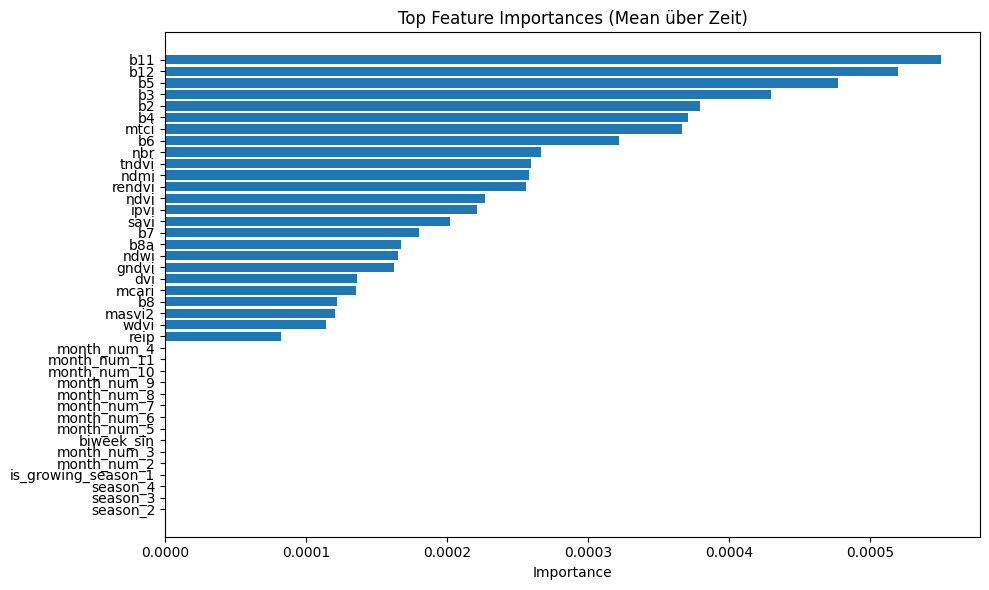

In [44]:
import matplotlib.pyplot as plt

top_n = 40
plt.figure(figsize=(10, 6))
plt.barh(importances_df["feature"].head(top_n), importances_df["mean_importance"].head(top_n))
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Mean über Zeit)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [45]:
pip.save_model()

In [46]:
pip.load_and_test()

Test (Loaded) Accuracy: 0.9171
Classification Report:
                     precision    recall  f1-score   support

      Norway_spruce       0.93      0.84      0.88       994
Norway_spruce_mixed       0.87      0.94      0.90      1662
         Scots_pine       0.93      0.98      0.95      1193
              beech       0.89      0.94      0.92       295
          disturbed       0.95      0.82      0.88       684
                oak       0.96      0.84      0.90        93
               soil       0.97      0.98      0.98       721

           accuracy                           0.92      5642
          macro avg       0.93      0.90      0.91      5642
       weighted avg       0.92      0.92      0.92      5642

Confusion Matrix:
[[ 830  151    4    1    3    0    5]
 [  51 1555   12   24   10    2    8]
 [   0   15 1165    0   10    1    2]
 [   0   16    0  278    0    0    1]
 [   8   35   75    1  561    0    4]
 [   0    7    1    5    1   78    1]
 [   0    3    1    2    8